### Required Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

Dummy plot as plotting with `pandas` first breaks other libraries.

In [2]:
plt.figure(figsize=(0, 0))
plt.show()

<Figure size 0x0 with 0 Axes>

### Utility Functions

**Removing outliers:**

In [3]:
from typing import Literal, overload


def clean_outliers (
    df: pd.DataFrame,
    *,
    mode: Literal["median", "mean", "drop"] = "median",
    inplace: Literal[False] = False
) -> None:
    ...


def clean_outliers (
    df: pd.DataFrame,
    *,
    mode: Literal["median", "mean", "drop"] = "median",
    inplace: Literal[True]
) -> None:
    ...

# Dataset passed must be devoid of null values or non-numeric columns
# Mode can return multiple values per column so it ain't an option
def clean_outliers (
    df: pd.DataFrame,
    *,
    mode: Literal["median", "mean", "drop"] = "median",
    inplace: bool = False
) -> pd.DataFrame | None:
    q1: pd.Series = df.quantile(0.25)
    q3: pd.Series = df.quantile(0.75)
    iqr: pd.Series = q3 - q1
    ll: pd.Series = q1 - 1.5 * iqr
    ul: pd.Series = q3 + 1.5 * iqr
    if mode == "median":
        df2: pd.DataFrame = df.mask((df < ll) | (df > ul), df.median(), axis=1, inplace=inplace)
    elif mode == "mean":
        df2: pd.DataFrame = df.mask((df < ll) | (df > ul), df.mean(), axis=1, inplace=inplace)
    elif mode == "drop":
        df2: pd.DataFrame = df if inplace else df.copy()
        for i in df.columns:
            df2.drop(df2[i][(df2[i] < ll[i]) | (df2[i] > ul[i])].index, inplace=True)
    else:
        raise Exception('Mode must be either "median", "mean" or "drop".')
    if not inplace:
        return df2

**Calculating y ndarray for given x with polynomial:**

In [4]:
# Degree must be greater than 1
def y_val_for_x (
    x_values: np.ndarray,
    degree: int,
    intercept: float | np.ndarray,
    coefficients: np.ndarray
) -> np.ndarray:
    y_values: np.ndarray = intercept + coefficients[1] * x_values
    for i in range(2, degree+1):
        y_values += coefficients[i] * (x_values ** i)
    return y_values

### Given Data

**1.** Import the dataset.

In [5]:
# cyl (No. of Cylinders): 4, 6, 8 -> Categorical
# vs (Engine Shape): V Shape or Straight -> Categorical
# am (Engine Type): Automatic or Manual -> Categorical
# gear (No. of Gears): 3, 4, 5 -> Categorical
# carb (No. of Carburetors): 1, 2, 3, 4, 6, 8 -> Categorical
data: pd.DataFrame = pd.read_csv(
    r"..\Datasets\Week3\mtcars.csv",
    dtype={"cyl": "category", "vs": "category", "am": "category", "gear": "category", "carb": "category"}
)
data

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


### Preprocessing Data

- Filter out non-numeric columns.

In [6]:
given_data = data.select_dtypes(include="number")
given_data

,mpg,disp,hp,drat,wt,qsec
0,21.0,160.0,110,3.90,2.620,16.46
1,21.0,160.0,110,3.90,2.875,17.02
2,22.8,108.0,93,3.85,2.320,18.61
3,21.4,258.0,110,3.08,3.215,19.44
4,18.7,360.0,175,3.15,3.440,17.02
5,18.1,225.0,105,2.76,3.460,20.22
6,14.3,360.0,245,3.21,3.570,15.84
7,24.4,146.7,62,3.69,3.190,20.00
8,22.8,140.8,95,3.92,3.150,22.90
9,19.2,167.6,123,3.92,3.440,18.30


- Check for missing data.

In [7]:
given_data.isna().value_counts()

mpg    disp   hp     drat   wt     qsec 
False  False  False  False  False  False    32
Name: count, dtype: int64

*No missing data present.*

- Check for outliers.

<Axes: >

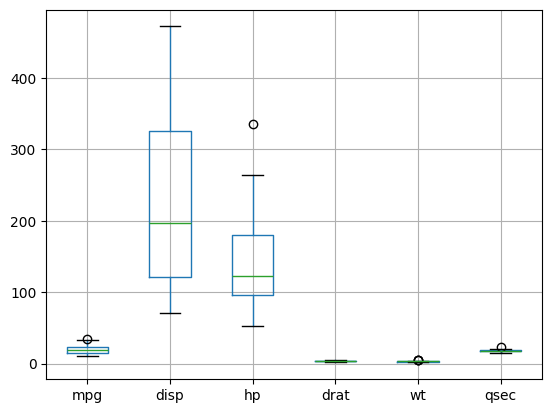

In [8]:
given_data.boxplot()

- Clean outliers.

In [9]:
clean_outliers(given_data, mode="median", inplace=True)
given_data

,mpg,disp,hp,drat,wt,qsec
0,21.0,160.0,110,3.90,2.620,16.46
1,21.0,160.0,110,3.90,2.875,17.02
2,22.8,108.0,93,3.85,2.320,18.61
3,21.4,258.0,110,3.08,3.215,19.44
4,18.7,360.0,175,3.15,3.440,17.02
5,18.1,225.0,105,2.76,3.460,20.22
6,14.3,360.0,245,3.21,3.570,15.84
7,24.4,146.7,62,3.69,3.190,20.00
8,22.8,140.8,95,3.92,3.150,17.71
9,19.2,167.6,123,3.92,3.440,18.30


- Boxplot for comparison after cleaning.

<Axes: >

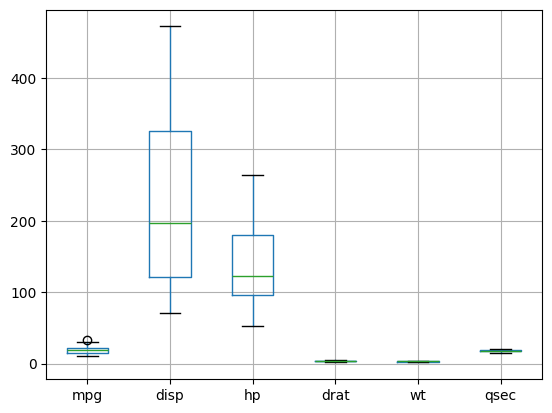

In [10]:
given_data.boxplot()

## Regressions:

### 1) Linear

- Analyze which columns are suited for linear regression.

*Observing heatmap of correlation matrix.*

<Axes: >

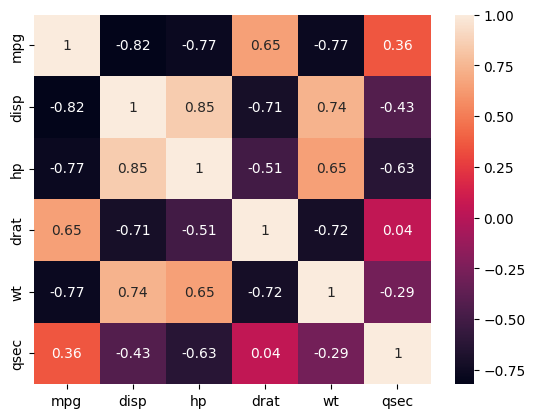

In [11]:
sns.heatmap(given_data.corr(), annot=True)

*Comparing with pair plot for validating results.*

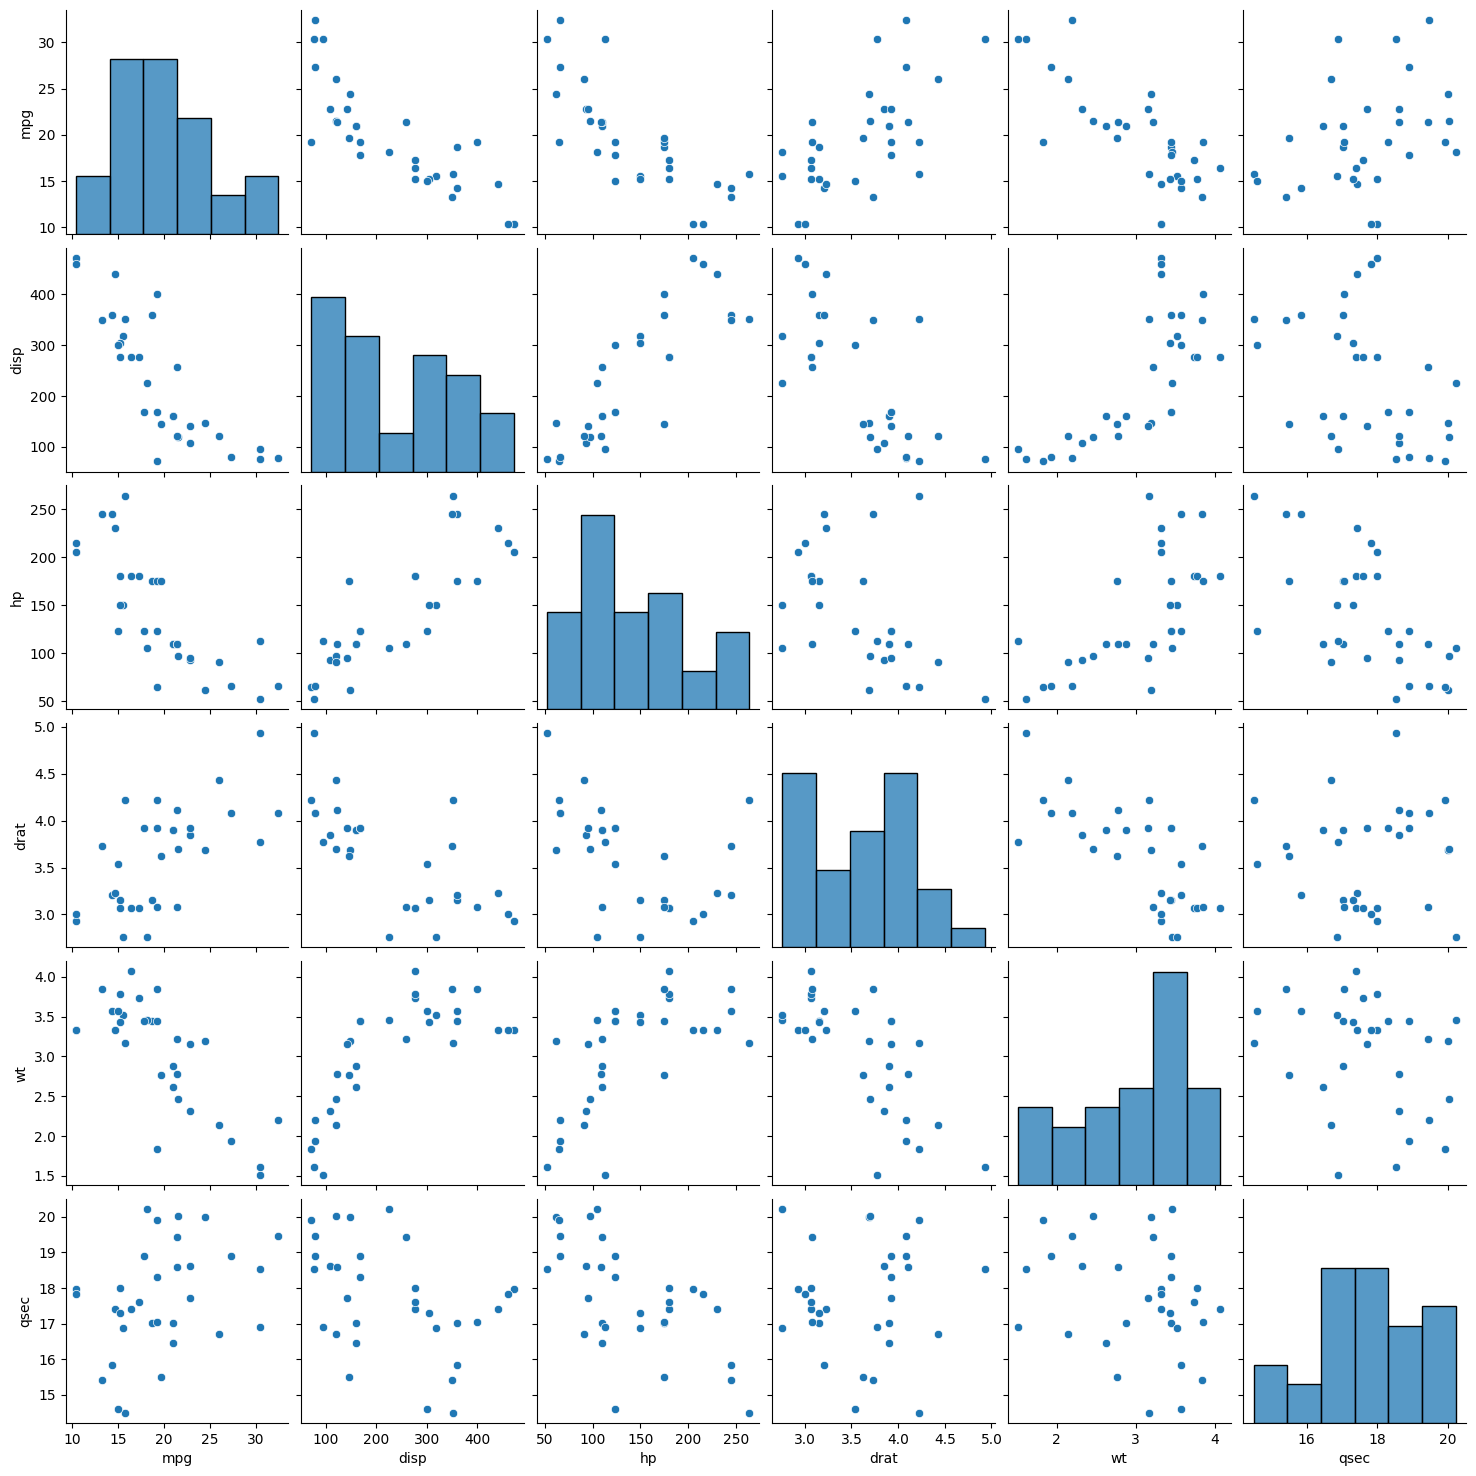

In [12]:
sns.pairplot(given_data)

<i>Here, we select the columns `drat` and `wt` for regression. Consider weight (`wt`) as x and driveshaft ratio (`drat`) as y.

**Note:** Even though columns `disp` and `hp` have most correlation, their distribution of points is slightly uneven (a group of points at one spot) unlike that of `drat` and `wt`, which are aligned along a single direction.</i>

In [13]:
x: pd.DataFrame = given_data[["wt"]]
y: pd.Series = given_data["drat"]

- Plot scatter plot between the columns.

<Axes: xlabel='wt', ylabel='drat'>

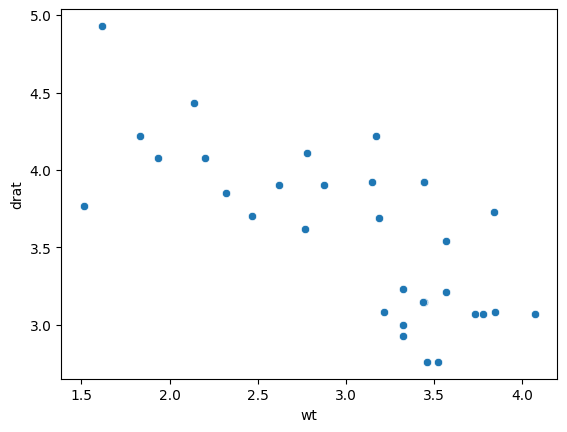

In [14]:
sns.scatterplot(x=x.iloc[:,0], y=y)

- Split data into training and testing sets.

In [15]:
# Fixing test data size as 30% of total
# random_state ensures that the testing data is the same across kernel restarts
# 0 and 42 are standard values for random_state
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

*Training data:*

In [16]:
pd.concat([x_train, y_train], axis=1)

,wt,drat
24,3.845,3.08
5,3.460,2.76
17,2.200,4.08
8,3.150,3.92
30,3.570,3.54
25,1.935,4.08
23,3.840,3.73
1,2.875,3.90
31,2.780,4.11
6,3.570,3.21


*Testing data:*

In [17]:
pd.concat([x_test, y_test], axis=1)

,wt,drat
11,4.070,3.07
22,3.435,3.15
10,3.440,3.92
2,2.320,3.85
16,3.325,3.23
14,3.325,2.93
28,3.170,4.22
26,2.140,4.43
20,2.465,3.70
13,3.780,3.07


- Train the regression model.

In [18]:
model: LinearRegression = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

- Get the regression line equation.

In [19]:
print(f"Line equation: y = ({model.coef_[0]})x + ({model.intercept_})")

Line equation: y = (-0.5422949702302414)x + (5.227577193723935)


- Plot the regression line.

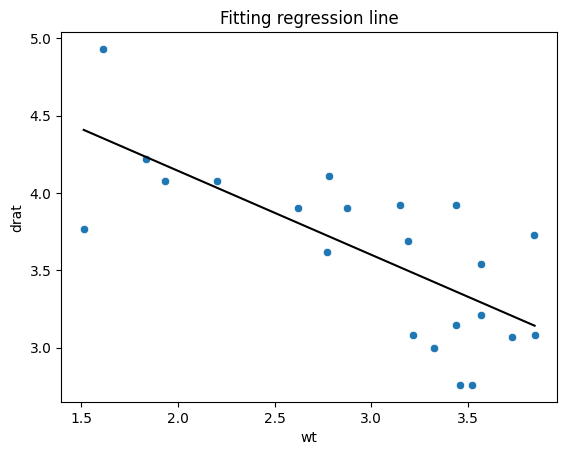

In [20]:
sns.scatterplot(x=x_train.iloc[:, 0], y=y_train)

x_values: np.ndarray = np.linspace(x_train.iloc[:, 0].min(), x_train.iloc[:, 0].max())
y_values: np.ndarray = model.intercept_ + model.coef_[0]*x_values
plt.plot(x_values, y_values, color="black")

plt.title("Fitting regression line")
plt.show()

- Test model by predicting values for test data.

In [21]:
temp_data: pd.DataFrame = pd.concat([x_test, y_test], axis=1)
temp_data["predicted_y"] = model.predict(x_test)

temp_data

,wt,drat,predicted_y
11,4.070,3.07,3.020437
22,3.435,3.15,3.364794
10,3.440,3.92,3.362082
2,2.320,3.85,3.969453
16,3.325,3.23,3.424446
14,3.325,2.93,3.424446
28,3.170,4.22,3.508502
26,2.140,4.43,4.067066
20,2.465,3.70,3.890820
13,3.780,3.07,3.177702


- Plot expected vs predicted values graph.

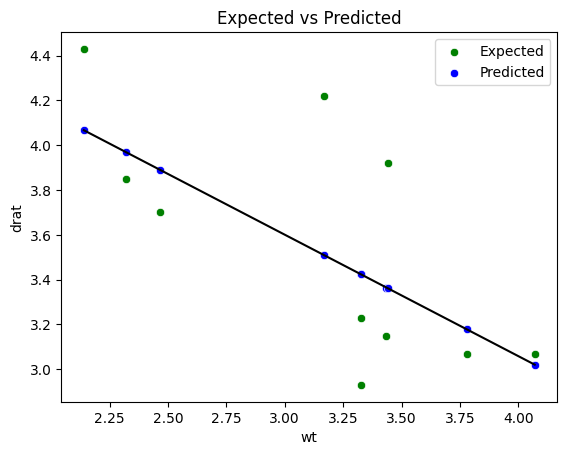

In [22]:
sns.scatterplot(x=x_test.iloc[:, 0], y=y_test, color="green") # Expected
sns.scatterplot(x=x_test.iloc[:, 0], y=temp_data["predicted_y"], color="blue") # Predicted

plt.legend({
    "Expected": "green",
    "Predicted": "blue"
})

x_values: np.ndarray = np.linspace(x_test.iloc[:, 0].min(), x_test.iloc[:, 0].max())
y_values: np.ndarray = model.intercept_ + model.coef_[0] * x_values
plt.plot(x_values, y_values, color="black")

plt.title("Expected vs Predicted")
plt.show()

- Calculate evaluation metrics.

*Mean Absolute Error:*

In [23]:
mean_absolute_error(y_test, temp_data["predicted_y"])

0.30035747110055616

*Mean Squared Error:*

In [24]:
mean_squared_error(y_test, temp_data["predicted_y"])

0.13423829705889784

*R² Score:*

In [25]:
r2_score(y_test, temp_data["predicted_y"])

0.47965820328280817

*Root Mean Squared Error:*

In [26]:
np.sqrt(mean_squared_error(y_test, temp_data["predicted_y"]))

0.366385448754311

### 2) Multilinear

- Select a column to be used as the dependent variable. The rest will be used as independent variables.

*Comparing distributions using pair plot.*

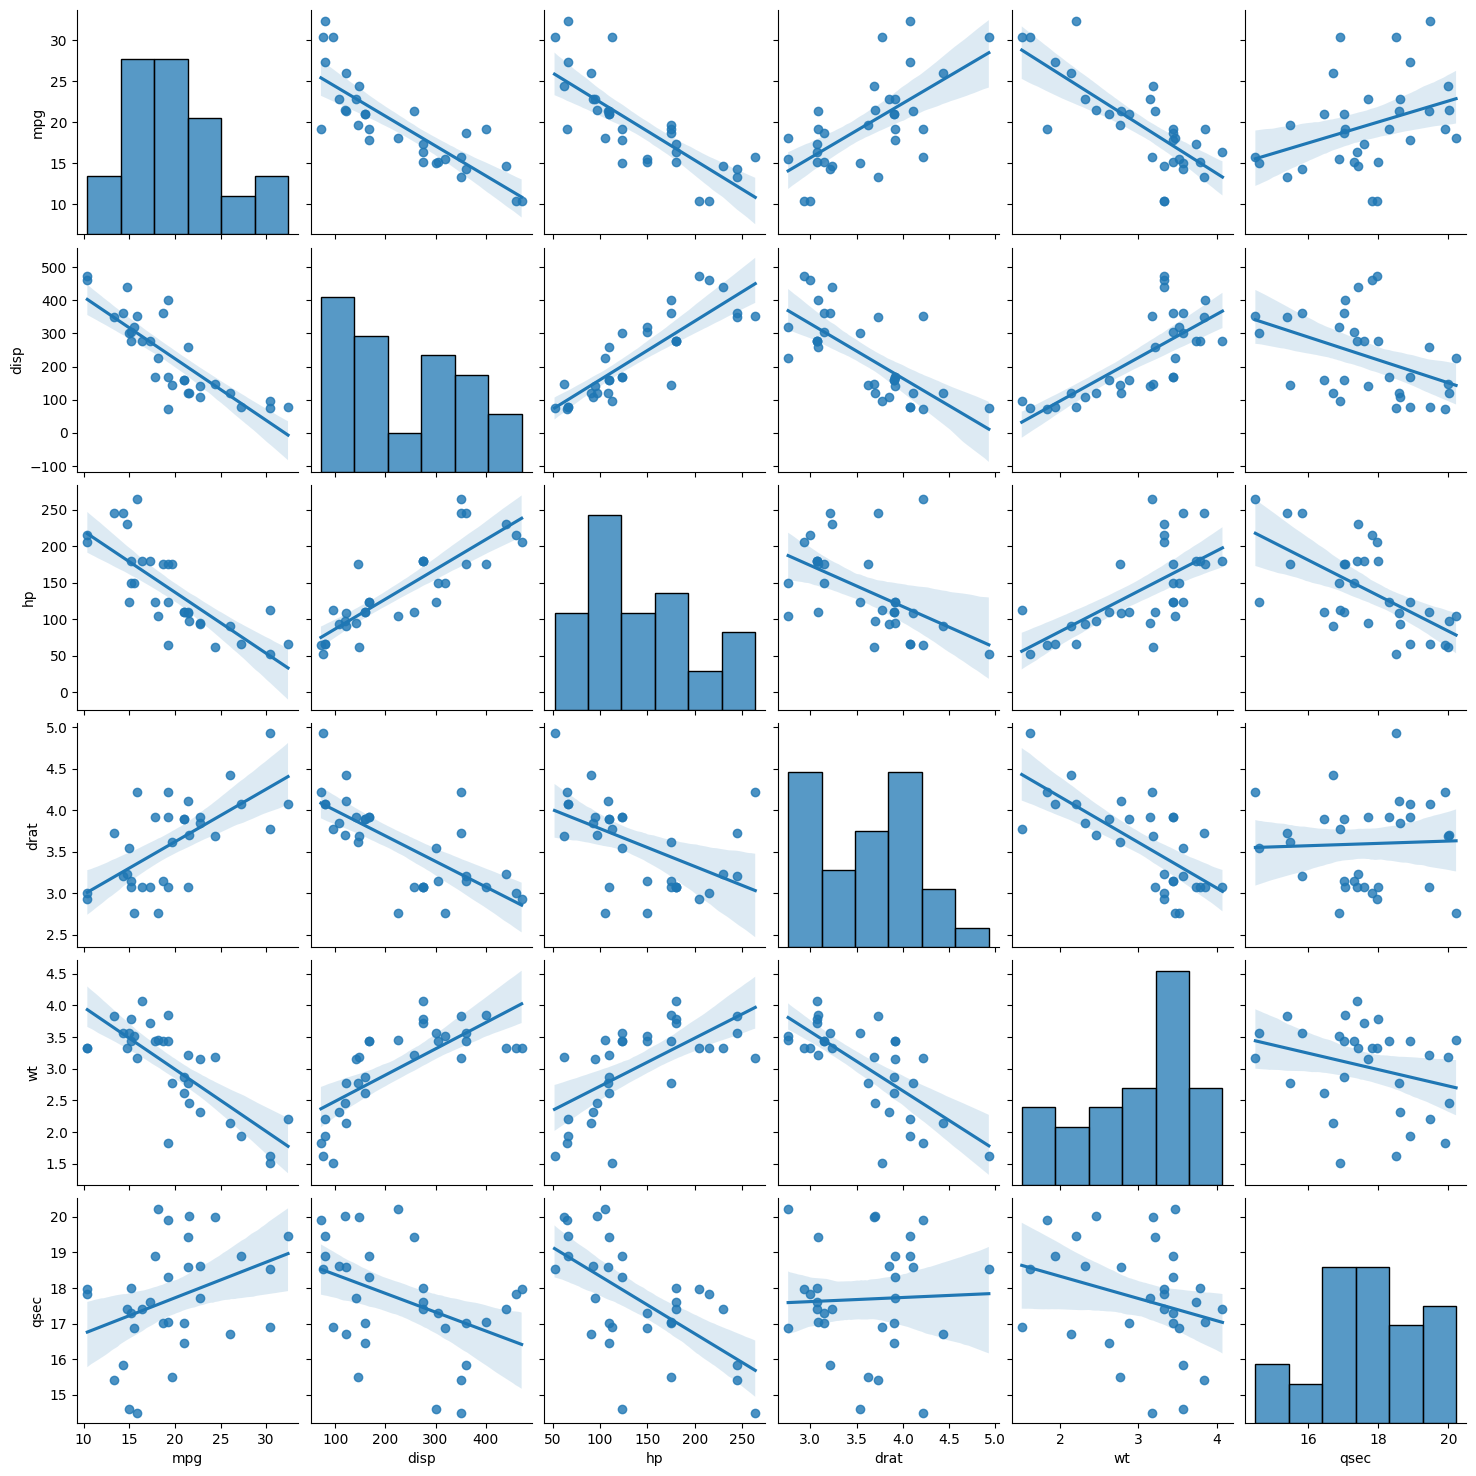

In [27]:
sns.pairplot(given_data, kind="reg")

*We select driveshaft ratio (`drat`) as the dependent variable as it has a balanced amount of columns with even distribution and columns with uneven distribution.*

In [28]:
dependent_label: str = "drat"
x: pd.DataFrame = given_data[[i for i in given_data.columns if i != dependent_label]]
y: pd.Series = given_data[dependent_label]

- Split data into training and testing sets.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

*Training data:*

In [30]:
pd.concat([x_train, y_train], axis=1)

,mpg,disp,hp,wt,qsec,drat
24,19.2,400.0,175,3.845,17.05,3.08
5,18.1,225.0,105,3.460,20.22,2.76
17,32.4,78.7,66,2.200,19.47,4.08
8,22.8,140.8,95,3.150,17.71,3.92
30,15.0,301.0,123,3.570,14.60,3.54
25,27.3,79.0,66,1.935,18.90,4.08
23,13.3,350.0,245,3.840,15.41,3.73
1,21.0,160.0,110,2.875,17.02,3.90
31,21.4,121.0,109,2.780,18.60,4.11
6,14.3,360.0,245,3.570,15.84,3.21


*Testing data:*

In [31]:
pd.concat([x_test, y_test], axis=1)

,mpg,disp,hp,wt,qsec,drat
11,16.4,275.8,180,4.070,17.40,3.07
22,15.2,304.0,150,3.435,17.30,3.15
10,17.8,167.6,123,3.440,18.90,3.92
2,22.8,108.0,93,2.320,18.61,3.85
16,14.7,440.0,230,3.325,17.42,3.23
14,10.4,472.0,205,3.325,17.98,2.93
28,15.8,351.0,264,3.170,14.50,4.22
26,26.0,120.3,91,2.140,16.70,4.43
20,21.5,120.1,97,2.465,20.01,3.70
13,15.2,275.8,180,3.780,18.00,3.07


- Train the regression model.

In [32]:
model: LinearRegression = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

- Get the regression line equation.

In [33]:
print(f"Line equation: y = ({model.intercept_})", *(f"+ ({model.coef_[i]})x{i+1}" for i in range(len(x.columns))))

Line equation: y = (6.410099836807837) + (-0.0015745187419935146)x1 + (-0.0027188317691674954)x2 + (-0.0005496763506258992)x3 + (-0.22516227192608948)x4 + (-0.08112121617565858)x5


- Test model by predicting values for test data.

In [34]:
temp_data: pd.DataFrame = pd.concat([x_test, y_test], axis=1)
temp_data["predicted_y"] = model.predict(x_test)

temp_data

,mpg,disp,hp,wt,qsec,drat,predicted_y
11,16.4,275.8,180,4.070,17.40,3.07,3.207563
22,15.2,304.0,150,3.435,17.30,3.15,3.300361
10,17.8,167.6,123,3.440,18.90,3.92,3.551038
2,22.8,108.0,93,2.320,18.61,3.85,3.997405
16,14.7,440.0,230,3.325,17.42,3.23,2.902447
14,10.4,472.0,205,3.325,17.98,2.93,2.790529
28,15.8,351.0,264,3.170,14.50,4.22,3.395776
26,26.0,120.3,91,2.140,16.70,4.43,4.155495
20,21.5,120.1,97,2.465,20.01,3.70,3.818137
13,15.2,275.8,180,3.780,18.00,3.07,3.226076


- Calculate evaluation metrics.

*Mean Absolute Error:*

In [35]:
mean_absolute_error(y_test, temp_data["predicted_y"])

0.2644258144956798

*Mean Squared Error:*

In [36]:
mean_squared_error(y_test, temp_data["predicted_y"])

0.11191513315719992

*R² Score:*

In [37]:
r2_score(y_test, temp_data["predicted_y"])

0.566188466758405

*Root Mean Squared Error:*

In [38]:
np.sqrt(mean_squared_error(y_test, temp_data["predicted_y"]))

0.3345371924871731

### 3) Polynomial

- Analyze which columns are suited for polynomial regression.

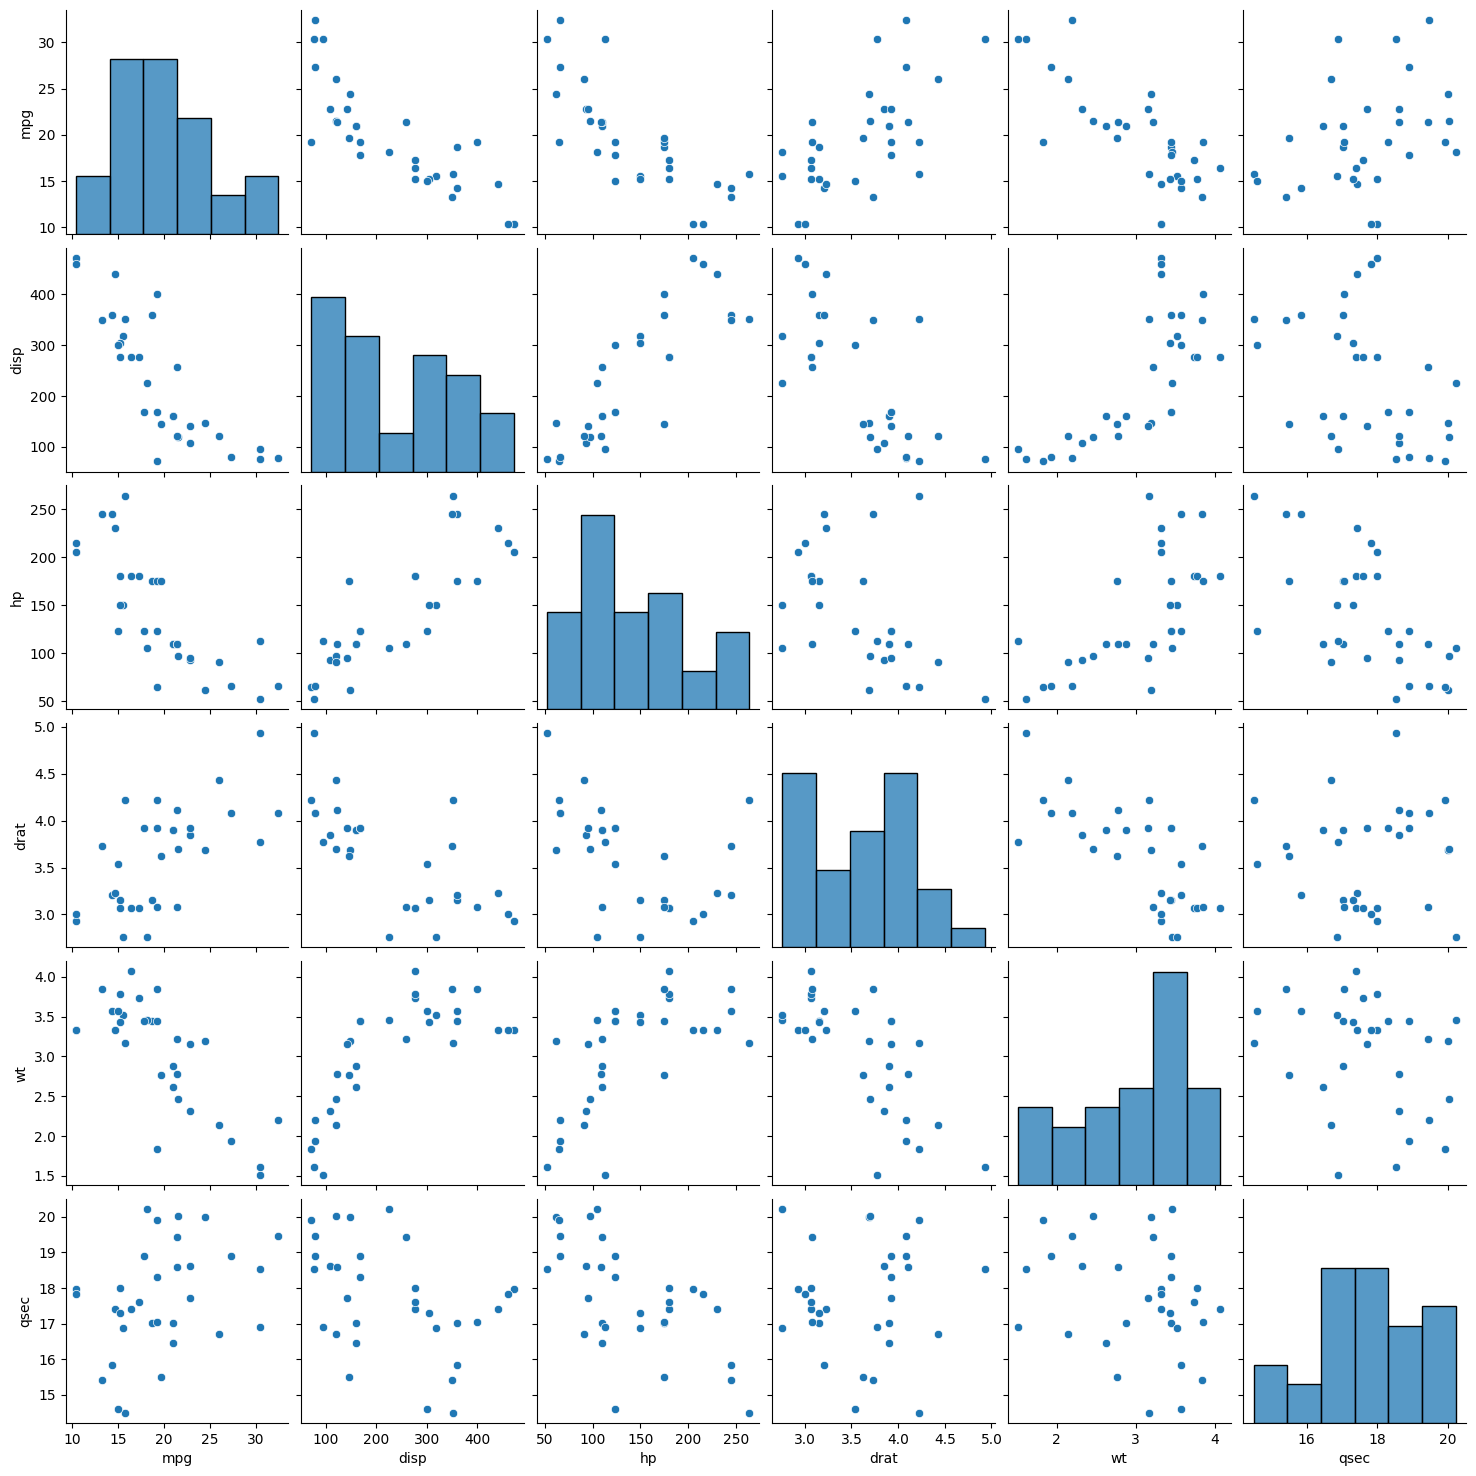

In [39]:
sns.pairplot(given_data)

*We select `disp` and `wt` for the polynomial regression as the scatter plot is curved which is often represents a higher order polynomial. Considering weight (`wt`) as x and displacement (`disp`) as y.*

In [40]:
x: pd.DataFrame = given_data[["wt"]]
y: pd.Series = given_data["disp"]

- Plot scatter plot between the columns.

<Axes: xlabel='wt', ylabel='disp'>

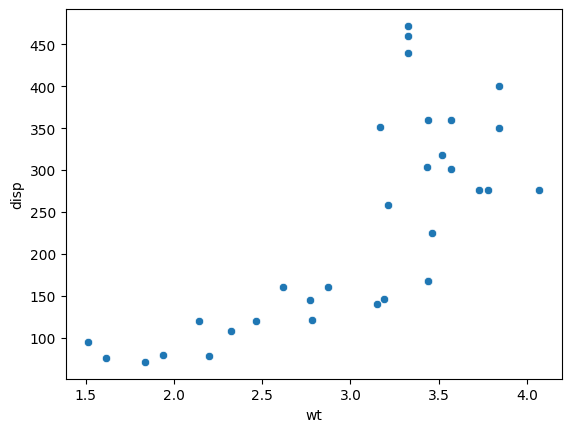

In [41]:
sns.scatterplot(x=x.iloc[:, 0], y=y)

- Split data into training and testing sets.

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

*Training data:*

In [43]:
pd.concat([x_train, y_train], axis=1)

,wt,disp
24,3.845,400.0
5,3.460,225.0
17,2.200,78.7
8,3.150,140.8
30,3.570,301.0
25,1.935,79.0
23,3.840,350.0
1,2.875,160.0
31,2.780,121.0
6,3.570,360.0


*Testing data:*

In [44]:
pd.concat([x_test, y_test], axis=1)

,wt,disp
11,4.070,275.8
22,3.435,304.0
10,3.440,167.6
2,2.320,108.0
16,3.325,440.0
14,3.325,472.0
28,3.170,351.0
26,2.140,120.3
20,2.465,120.1
13,3.780,275.8


- Train the regression model.

In [45]:
degree: int = 5
poly_reg: PolynomialFeatures = PolynomialFeatures(degree=degree)
x_poly: np.ndarray = poly_reg.fit_transform(x_train)
model: LinearRegression = LinearRegression()
model.fit(x_poly, y_train)

LinearRegression()

*Repeated evaluations with different degrees showed that degree 5 had the least errors.*

- Get the regression curve equation.

In [46]:
print(f"Curve equation: y = ({model.intercept_})", *(f"+ ({model.coef_[i]})x^{i}" for i in range(1, degree+1)))

Curve equation: y = (2737.1713076883016) + (-5343.060500182436)x^1 + (4275.241872352392)x^2 + (-1714.7996125259992)x^3 + (344.6636618635762)x^4 + (-27.24384092863238)x^5


- Plot the regression curve.

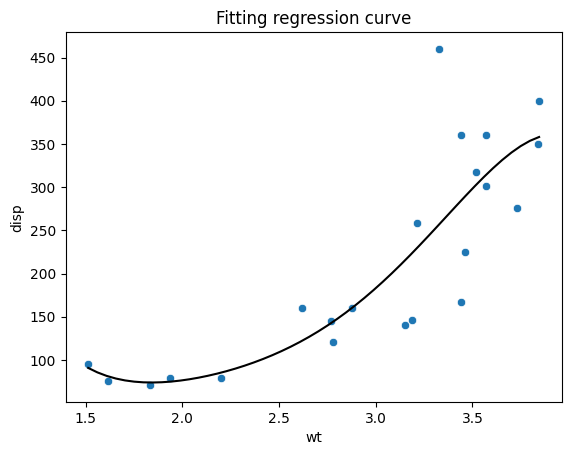

In [47]:
sns.scatterplot(x=x_train.iloc[:, 0], y=y_train)

x_values: np.ndarray = np.linspace(x_train.iloc[:, 0].min(), x_train.iloc[:, 0].max())
y_values: np.ndarray = y_val_for_x(x_values, degree, model.intercept_, model.coef_)
plt.plot(x_values, y_values, color="black")

plt.title("Fitting regression curve")
plt.show()

- Test model by predicting values for test data.

In [48]:
temp_data: pd.DataFrame = pd.concat([x_test, y_test], axis=1)
temp_data["predicted_y"] = model.predict(poly_reg.fit_transform(x_test))

temp_data

,wt,disp,predicted_y
11,4.070,275.8,348.162490
22,3.435,304.0,282.827412
10,3.440,167.6,284.029456
2,2.320,108.0,93.243459
16,3.325,440.0,256.151450
14,3.325,472.0,256.151450
28,3.170,351.0,219.487958
26,2.140,120.3,82.084786
20,2.465,120.1,105.492789
13,3.780,275.8,351.573539


- Plot expected vs predicted values graph.

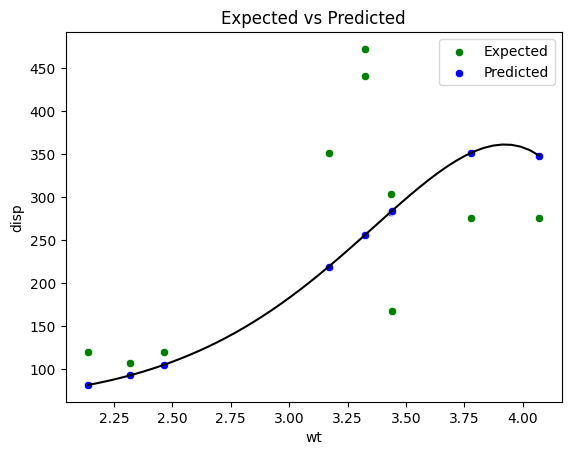

In [49]:
sns.scatterplot(x=x_test.iloc[:, 0], y=y_test, color="green") # Expected
sns.scatterplot(x=x_test.iloc[:, 0], y=temp_data["predicted_y"], color="blue") # Predicted

plt.legend({
    "Expected": "green",
    "Predicted": "blue"
})

x_values: np.ndarray = np.linspace(x_test.iloc[:, 0].min(), x_test.iloc[:, 0].max())
y_values: np.ndarray = y_val_for_x(x_values, degree, model.intercept_, model.coef_)
plt.plot(x_values, y_values, color="black")

plt.title("Expected vs Predicted")
plt.show()

- Calculate evaluation metrics.

*Mean Absolute Error:*

In [50]:
mean_absolute_error(y_test, temp_data["predicted_y"])

88.45261813858772

*Mean Squared Error:*

In [51]:
mean_squared_error(y_test, temp_data["predicted_y"])

12455.988779419491

*R² Score:*

In [52]:
r2_score(y_test, temp_data["predicted_y"])

0.2149772802384715

*Root Mean Squared Error:*

In [53]:
np.sqrt(mean_squared_error(y_test, temp_data["predicted_y"]))

111.60640115790622

### 4) Logistic

- Select category for logistic regression.

In [54]:
data["am"]

0     1
1     1
2     1
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    1
18    1
19    1
20    0
21    0
22    0
23    0
24    0
25    1
26    1
27    1
28    1
29    1
30    1
31    1
Name: am, dtype: category
Categories (2, object): ['0', '1']

*Engine Type (`am`) has only 2 values, 0 representing automatic transmission and 1 representing manual transmission. Hence, we choose this column for logistic regression.*

*Set category for logistic regression:*

In [55]:
logistic_category: str = "am"

*Adding categorical column to cleaned DataFrame:*

In [56]:
given_data[logistic_category] = data[logistic_category]
given_data

,mpg,disp,hp,drat,wt,qsec,am
0,21.0,160.0,110,3.90,2.620,16.46,1
1,21.0,160.0,110,3.90,2.875,17.02,1
2,22.8,108.0,93,3.85,2.320,18.61,1
3,21.4,258.0,110,3.08,3.215,19.44,0
4,18.7,360.0,175,3.15,3.440,17.02,0
5,18.1,225.0,105,2.76,3.460,20.22,0
6,14.3,360.0,245,3.21,3.570,15.84,0
7,24.4,146.7,62,3.69,3.190,20.00,0
8,22.8,140.8,95,3.92,3.150,17.71,0
9,19.2,167.6,123,3.92,3.440,18.30,0


- Select column to use for predicting category.

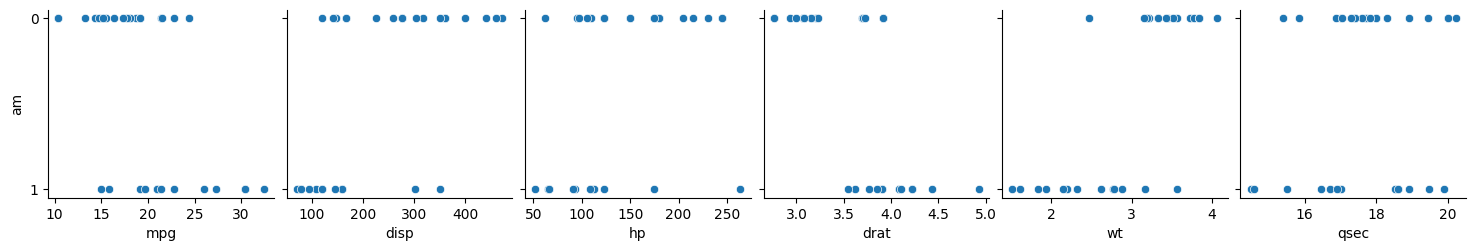

In [57]:
sns.pairplot(given_data, x_vars=[i for i in given_data.columns if i != logistic_category], y_vars=[logistic_category])

*The graph of `am` against `wt` represents even odds for certain parts of the data, hence we select weight (`wt`) as the column for predicting `am`.*

In [58]:
x: pd.DataFrame = given_data[["wt"]]
y: pd.Series = given_data[logistic_category]

- Plot scatter plot between the columns.

<Axes: xlabel='wt', ylabel='am'>

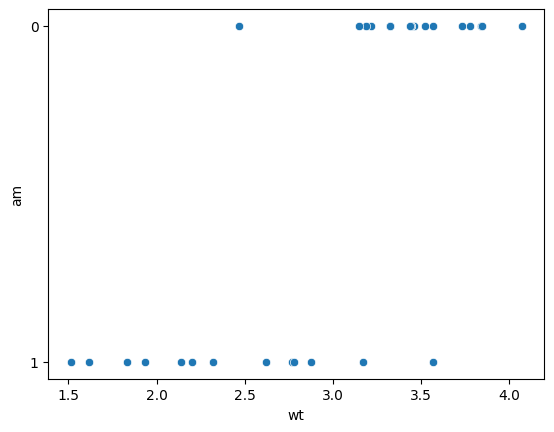

In [59]:
sns.scatterplot(x=x.iloc[:, 0], y=y)

- Split data into training and testing sets.

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

*Training data:*

In [61]:
pd.concat([x_train, y_train], axis=1)

,wt,am
24,3.845,0
5,3.460,0
17,2.200,1
8,3.150,0
30,3.570,1
25,1.935,1
23,3.840,0
1,2.875,1
31,2.780,1
6,3.570,0


*Testing data:*

In [62]:
pd.concat([x_test, y_test], axis=1)

,wt,am
11,4.070,0
22,3.435,0
10,3.440,0
2,2.320,1
16,3.325,0
14,3.325,0
28,3.170,1
26,2.140,1
20,2.465,0
13,3.780,0


- Train the regression model.

In [63]:
model: LogisticRegression = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

- Get the regression curve equation.

In [64]:
print(f"Curve equation: y = 1 / (1 + e^-(({model.intercept_[0]}) + ({model.coef_[0][0]})x))")

Curve equation: y = 1 / (1 + e^-((5.494269897755572) + (-1.892874041246883)x))


- Plot the regression curve.

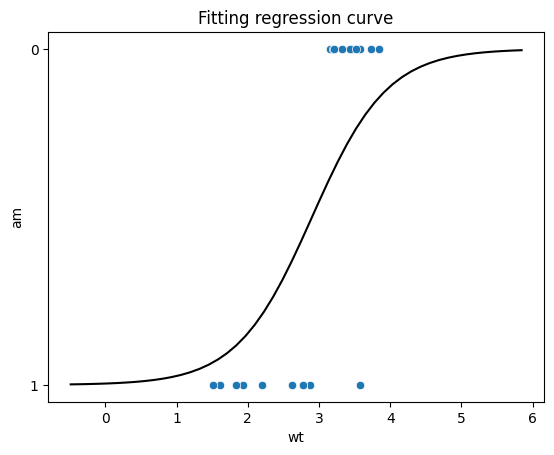

In [65]:
sns.scatterplot(x=x_train.iloc[:, 0], y=y_train)

x_values: np.ndarray = np.linspace(x_train.iloc[:, 0].min() - 2, x_train.iloc[:, 0].max() + 2)
y_values: np.ndarray = 1 / (1 + np.exp(-(model.intercept_[0] + model.coef_[0][0] * x_values)))
plt.plot(x_values, y_values, color="black")

plt.title("Fitting regression curve")
plt.show()

- Test model by predicting values for test data.

In [66]:
temp_data: pd.DataFrame = pd.concat([x_test, y_test], axis=1)
temp_data["predicted_y"] = model.predict(x_test)

temp_data

,wt,am,predicted_y
11,4.070,0,0
22,3.435,0,0
10,3.440,0,0
2,2.320,1,1
16,3.325,0,0
14,3.325,0,0
28,3.170,1,0
26,2.140,1,1
20,2.465,0,1
13,3.780,0,0


- Plot expected vs predicted values graph.

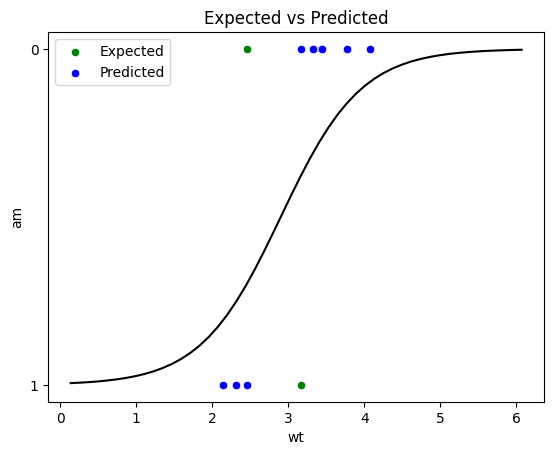

In [67]:
sns.scatterplot(x=x_test.iloc[:, 0], y=y_test, color="green") # Expected
sns.scatterplot(x=x_test.iloc[:, 0], y=temp_data["predicted_y"], color="blue") # Predicted

plt.legend({
    "Expected": "green",
    "Predicted": "blue"
})

x_values: np.ndarray = np.linspace(x_test.iloc[:, 0].min() - 2, x_test.iloc[:, 0].max() + 2)
y_values: np.ndarray = 1 / (1 + np.exp(-(model.intercept_[0] + model.coef_[0][0] * x_values)))
plt.plot(x_values, y_values, color="black")

plt.title("Expected vs Predicted")
plt.show()

- Calculate evaluation metrics.

*Confusion Matrix:*

In [68]:
pd.DataFrame(
    confusion_matrix(y_test, temp_data["predicted_y"]),
    index=["Predicted Negative", "Predicted Positive"],
    columns=["Actual Negative", "Actual Positive"]
)

,Actual Negative,Actual Positive
Predicted Negative,6,1
Predicted Positive,1,2


*Precision, Recall and F1-Score:*

In [69]:
print(classification_report(y_test, temp_data["predicted_y"]))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.67      0.67      0.67         3

    accuracy                           0.80        10
   macro avg       0.76      0.76      0.76        10
weighted avg       0.80      0.80      0.80        10

